In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Add project root to path to import config
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

from config.constants import PROCESSED_IMAGE_DATA_DIR, CLEANED_IMAGE_DATA_DIR, MODELS_DIR
from utils.image_processing import get_image_generator
from utils.model_builder import build_resnet50_model
from utils.train_utils import calculate_class_weights
from utils.plot import plot_training_history

2025-12-13 15:38:49.125667: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-13 15:38:49.788166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 15:38:52.122328: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 1. Load Data & Split

In [2]:
# Load CSV
csv_path = PROCESSED_IMAGE_DATA_DIR / "instruments.csv"
df = pd.read_csv(csv_path)

# Split into Train (80%) and Validation (20%)
# We use stratify to ensure the class distribution is similar in both sets
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 4074
Validation samples: 1019


## 2. Setup Data Generators

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Initialize Generator (Preprocessing only, no augmentation for now)
datagen = get_image_generator()

# Train Generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=CLEANED_IMAGE_DATA_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# Validation Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=CLEANED_IMAGE_DATA_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False # No shuffling for validation
)

Found 4074 validated image filenames belonging to 30 classes.
Found 1019 validated image filenames belonging to 30 classes.


## 3. Calculate Class Weights
To address the class imbalance (e.g., Tambourine vs Marakas), we calculate weights.

In [4]:
# The generator's 'classes' attribute contains the class indices for each sample
class_weights = calculate_class_weights(train_generator.classes)

print("Class Weights:")
# Map indices back to names for display
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

for idx, weight in list(class_weights.items())[:5]: # Show first 5
    print(f"{index_to_class[idx]}: {weight:.4f}")

Class Weights:
Didgeridoo: 1.0952
Tambourine: 0.5956
Xylophone: 0.7895
acordian: 0.7760
alphorn: 1.1809


## 4. Build Model (ResNet50)

In [5]:
num_classes = len(train_generator.class_indices)

model = build_resnet50_model(num_classes)
model.summary()

2025-12-13 15:39:23.485051: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 44s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,652,190 (94.04 MB)

 Trainable params: 1,064,478 (4.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 5. Train Model

In [6]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save best model
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODELS_DIR, 'resnet50_instrument_classifier.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train
history = model.fit(
    train_generator,
    epochs=20, # Start with 20, early stopping will likely stop it sooner
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20


2025-12-13 15:40:53.500570: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-13 15:40:53.791668: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 106463232 exceeds 10% of free system memory.
2025-12-13 15:40:54.260145: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-13 15:40:54.508549: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-13 15:40:54.878239: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6894 - loss: 1.2229
Epoch 1: val_accuracy improved from None to 0.92542, saving model to /home/insane.beggar/Be-Serious/Learning/ENSET/S3/AI Advanced/Project/musical-instrument-classifier/models/resnet50_instrument_classifier.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.8370 - loss: 0.6000 - val_accuracy: 0.9254 - val_loss: 0.2400
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9616 - loss: 0.1018
Epoch 2: val_accuracy improved from 0.92542 to 0.93817, saving model to /home/insane.beggar/Be-Serious/Learning/ENSET/S3/AI Advanced/Project/musical-instrument-classifier/models/resnet50_instrument_classifier.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 591s 4s/step - accuracy: 0.9595 - loss: 0.1139 - val_accuracy: 0.9382 - val_loss: 0.1902
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9804 - loss: 0.0603
Epoch 3: val_accuracy did not improve from 0.93817
128/128 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step 

## 6. Evaluate & Save Metadata

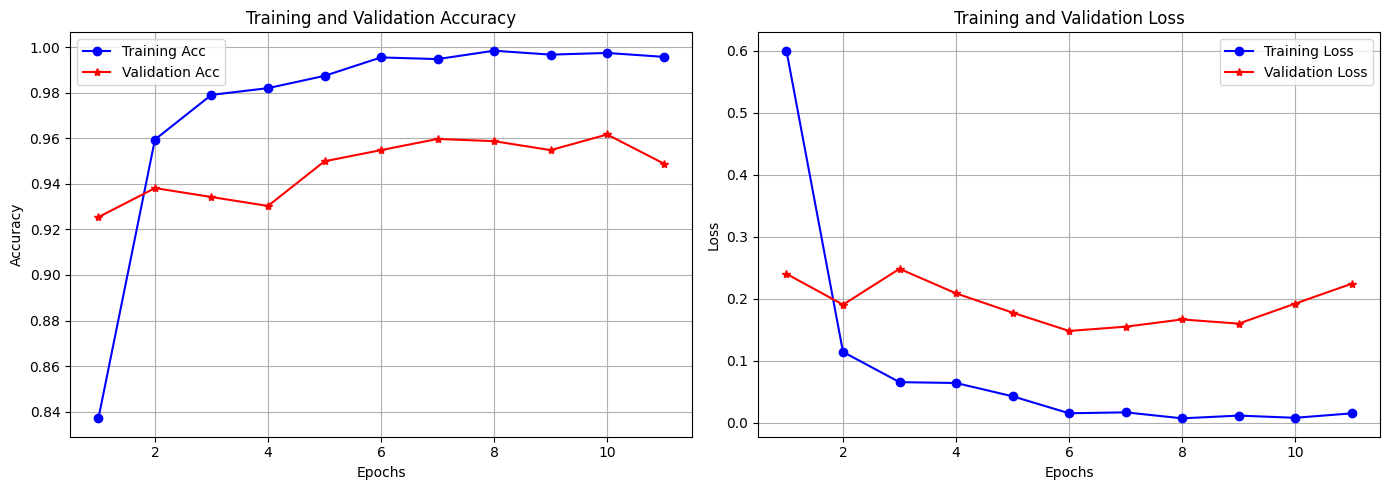

Model saved to: /home/insane.beggar/Be-Serious/Learning/ENSET/S3/AI Advanced/Project/musical-instrument-classifier/models/resnet50_instrument_classifier.keras
Class indices saved to: /home/insane.beggar/Be-Serious/Learning/ENSET/S3/AI Advanced/Project/musical-instrument-classifier/models/image_class_indices.pkl


In [7]:
# Plot History
plot_training_history(history)

# Save Class Indices (Label Mapping)
import pickle
class_indices_path = MODELS_DIR / 'image_class_indices.pkl'
with open(class_indices_path, 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

print(f"Model saved to: {os.path.join(MODELS_DIR, 'resnet50_instrument_classifier.keras')}")
print(f"Class indices saved to: {class_indices_path}")